# So, let's start working on it.

I will modify the existing book and will significantly add more **my** content to make sure we are correctly understanding the OOP here -- and how to do that with torch and d2l.

- This notebook will circle up the most of the classes and we will get to know how they are used.
- So, let's see some diagrams and when needed we will refer them.

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

# Things to keep on top of your head:

1. `d2l.save_hyperparameters()`: This will save all argument of the *current* function's init, as a class members (by assigning them to the self).
2. `d2l.ProgressBoard()`: A nifty tool to see the stuff live.
3. `d2l.Module()`: Handles the training, has `forward`, `loss`, `optimizers` as the **core** stuff.
4. `d2l.DataModule()`: Gives the minibatches of the requested sizes.
5. `d2l.Trainer()`: A highlevel godfather *(even above module)* to overlook everything. Involving the **core** like `prepare_model`, `prepare_data`, `fit` etc. 

# Keep these guys handy.

🔗 Access full resimage here: [Initial-Core](../images/initial-core.png)

<img src="../images/initial-core.png">

# 1️⃣ Defining the Model

In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    """
    *The linear regression model implemented from scratch.*
    
    This function will take number of features and learning rate.
    Based on which it will **initialize the memory** to create and learn gradients
    for the weights.

    Params
    ------
    1. num_inputs: ...
    2. lr: ...
    """
    def __init__(self, num_inputs, lr, sigma=0.01):
        # this will initialize the Module's init like forward, loss, training_step etc.
        # we need this in here -- tightly included with the model.
        super().__init__() 
        self.save_hyperparameters()

        # these will initialize the weights, which will have the random values
        # these will be learned
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Now, we will define the `forward` which will be the **actual** prediction. So, based on that we will create the loss and so on. It will actually *predict* the number.

# 2️⃣ Forward

#### Currently

```python
>>> LinearRegressionScratch.forward??

Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
```

> As you can see ☝🏻 it is nothing, as we are **wating** for some overriding (coming from `d2l.Module` refer the image)

In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    # this will perform the matmul with the random weights and the X
    return torch.matmul(X, self.w) + self.b

#### Now

```python
>>> LinearRegressionScratch.forward??

@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b
```

### 🤝 How will the shapes work?

<img src="../images/shapes-1.png">

# 3️⃣ Defining the Loss Function

#### Currently

This again comes from the `d2l.Module`. 

```python
>>> LinearRegressionScratch.loss??

def loss(self, y_hat, y):
        raise NotImplementedError
```

In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    # the matmul would have given the single scaler
    l = (y_hat - y) ** 2 / 2
    return l.mean() # taking mean is important

#### Now

```python
>>> LinearRegressionScratch.loss??

@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()
```

# 4️⃣ Defining the Optimization Algorithm

**Till now**:
- **Initialized** the model with the random weights
- We have defiend **forward** which shows how the model will work
- The loss is defined as well, thus we know **how to measure loss**.

Now we will need to define the optimizer which will does the heavy lifting for us.

In [5]:
class SGD(d2l.HyperParameters):  #@save
    """
    Minibatch stochastic gradient descent.

    This is an **independent** class. This is not related with 
    the linear model. Thus, it will have it's own implementation.
    """
    def __init__(self, params, lr):
        # we will accept the `params` and `learning rate` for this to work
        self.save_hyperparameters()

    def step(self):
        ## It answers the question: what happens in a single step?
        #  A: we will update the weights by their grad
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        ## before performing anything -- any update step we will need 
        #  to zero grad them
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


In [6]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

---
🔥 The `LinearRegressionScratch` is ready! Let's have a look!

<img src="../images/LinearRegressionFromScratch.png">

Simple?

---

# 5️⃣ Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


> Remember that `Trainer` is the guy which handles the high-level things. The `Module` is a guy which provides some information to the model that is needed. So model and module are closer.

<img src="../images/Trainer.png">

In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

👉🏻 About the **`fit_epoch`**:

1. Note that the `fit` and `fit_epoch` are different
2. `fit` is the highlevel wrapper of `fit_epoch`.
3. Fit will manage the optimizer, model, data etc.
4. `fit_epoch` will **actually** do the training and backprop.

In [8]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    # not sure what is it
    self.model.train()

    # gives the iterator and each batch at a time
    for batch in self.train_dataloader:
        # a scalar loss for *this* batch
        loss = self.model.training_step(self.prepare_batch(batch))
        
        # make all params - grads zero
        self.optim.zero_grad()
        with torch.no_grad():
            # calculate gradients
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)

            # update gradients
            self.optim.step()
        
        # update how many batches have been considered
        self.train_batch_idx += 1
    
    if self.val_dataloader is None:
        return

    # after the training, put the model in the evaluation
    # 1 epoch is `n` cycles of training of batches and single validation
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class 
and pass in some ground truth parameters.
Then we train our model with 
the learning rate `lr=0.03` 
and set `max_epochs=3`. 
Note that in general, both the number of epochs 
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a three-way split,
one set for training, 
a second for hyperparameter selection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.


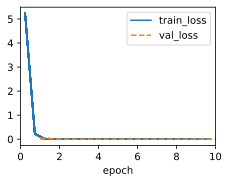

In [9]:
model = LinearRegressionScratch(2, lr=0.1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [10]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-0.0010, -0.0004])
error in estimating b: tensor([-0.0004])


Now the loss on entire data...

In [11]:
from sklearn.metrics import r2_score

In [12]:
pred = model.forward(data.X)
print("LOSS on entire data:", model.loss(pred, data.y).item())
print("R2 score:", r2_score(data.y.numpy(), pred.detach().numpy()))

LOSS on entire data: 5.061517731519416e-05
R2 score: 0.9999932646751404


🔥 Cool!!!

We should not take the ability to exactly recover 
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature 
is linearly dependent on the others.
However, in machine learning, 
we are often less concerned
with recovering true underlying parameters,
but rather with parameters 
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step 
towards designing deep learning systems 
by implementing a fully functional 
neural network model and training loop.
In this process, we built a data loader, 
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool. 
We did this by composing a Python object 
that contains all relevant components for training a model. 
While this is not yet a professional-grade implementation
it is perfectly functional and code like this 
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).





## Exercises

1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?
    - Done, I mean since the ground truth is available and it is easy, it does work. I tries with high learning rate of `0.1` and it just does its job in first 2 epochs.

# 🏋🏻 My Exercise
The data - module and everything provides too features, but quickly becomes a *chaos* as it has to store, perform, and show all charts, values and all.

So the *soul* of the model and how the forward and back prop works vanishes quickly.

---

<img src="../images/the-forward-flow.png">

---

Below is what I have prepared as a **manual way to train the model** and get the gradients, update the gradients and get the loss.

Let's do that. Because that is what is more important than just... running the cells

In [19]:
# STEP - 1: initializing weights that will be trained
weights = torch.randn(data.X.shape[1], 1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

In [22]:
# STEP - 2: forward pass
prediction = torch.matmul(data.X, weights) + bias

In [23]:
# initial prediction
prediction

tensor([[-0.4547],
        [ 1.4853],
        [ 1.4876],
        ...,
        [ 2.9355],
        [-0.6599],
        [-0.7060]], grad_fn=<AddBackward0>)

In [27]:
# STEP - 3: Calculate the loss
loss = (data.y - prediction) ** 2 / 2
loss = loss.mean()

In [30]:
# currently we don't have any grad
type(weights.grad)

NoneType

In [31]:
# STEP - 4: Calculate the grad
loss.backward()

In [33]:
# now we have the grad!
type(weights.grad), weights.grad

(torch.Tensor,
 tensor([[-0.1474],
         [ 3.0641]]))

> The above grad are the the un-trained and initial grad... which we will update.

In [34]:
# STEP - 5: Update the weights
# old weights
weights

tensor([[ 1.7796],
        [-0.3154]], requires_grad=True)

In [38]:
# updated weights
learning_rate = 0.03
with torch.no_grad(): # this is needed
    weights -= learning_rate * weights.grad
    bias -= learning_rate * bias.grad

In [41]:
# new weights
weights

tensor([[ 1.7840],
        [-0.4073]], requires_grad=True)

In [42]:
# STEP - 6: reset the grad
if weights.grad is not None:
    print("ZEROED")
    weights.grad.zero_()

if bias.grad is not None:
    print("ZEROED")
    bias.grad.zero_()

ZEROED
ZEROED


Done! Now just run this in a loop until we get our loss to some acceptable level!

In [45]:
from tqdm.notebook import tqdm

In [53]:
## The epochs
learning_rate = 0.05
losses = []
for i in tqdm(range(100)):
    prediction = torch.matmul(data.X, weights) + bias
    
    loss = (data.y - prediction) ** 2 / 2
    loss = loss.mean()
    losses.append(loss.item())

    if weights.grad is not None:
        weights.grad.zero_()
    
    if bias.grad is not None:
        bias.grad.zero_()

    with torch.no_grad(): # this is needed
        loss.backward()
        weights -= learning_rate * weights.grad
        bias -= learning_rate * bias.grad

print(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

5.837060962221585e-05


In [58]:
# OUR ESTIMATED PARAMETERS
weights, bias

(tensor([[ 1.9996],
         [-3.3974]], requires_grad=True),
 tensor([4.1977], requires_grad=True))

In [59]:
# THE ACTUAL PARAMETERS
data.w, data.b

(tensor([ 2.0000, -3.4000]), 4.2)

# How was that!!?

[Discussions](https://discuss.d2l.ai/t/43)
